In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def read_fasta(file_path):
    """
    Reads a FASTA-like file and returns a dictionary with sequence names as keys
    and sequences as values.
    """
    sequences = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 2):
            name = lines[i].strip()  # Sequence name
            sequence = lines[i + 1].strip()  # DNA sequence
            sequences[name] = sequence
    return sequences

In [3]:
def calculate_nucleotide_composition(sequence):
    """
    Calculates the nucleotide composition of a given DNA sequence.
    Returns a dictionary with counts of A, T, C, G.
    """
    composition = {
        'A': sequence.upper().count('A'),
        'T': sequence.upper().count('T'),
        'C': sequence.upper().count('C'),
        'G': sequence.upper().count('G')
    }
    return composition

In [4]:
# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Construct the path to the data directory relative to the notebook
data_path = os.path.abspath(os.path.join(notebook_dir, "..", "..", "data", "enhancer_classification"))

# Check if the data directory exists
if not os.path.isdir(data_path):
    raise FileNotFoundError(f"Data directory not found: {data_path}")

strong_enhancer_file = os.path.join(data_path, "strong_742_train.txt")
weak_enhancer_file = os.path.join(data_path, "weak_742_train.txt")

# Read sequences from files
enhancer_sequences = read_fasta(strong_enhancer_file)
non_enhancer_sequences = read_fasta(weak_enhancer_file)

# # Calculate nucleotide compositions for enhancer sequences
# print("Enhancer Sequences Nucleotide Composition:")
# for name, sequence in enhancer_sequences.items():
#     composition = calculate_nucleotide_composition(sequence)
#     print(f"{name}: {composition}")

# # Calculate nucleotide compositions for non-enhancer sequences
# print("\nNon-Enhancer Sequences Nucleotide Composition:")
# for name, sequence in non_enhancer_sequences.items():
#     composition = calculate_nucleotide_composition(sequence)
#     print(f"{name}: {composition}")

In [5]:
def calculate_nucleotide_frequencies(sequence_dict):
    """
    Calculates nucleotide frequencies for a dictionary of DNA sequences.
    
    Args:
        sequence_dict (dict): Dictionary with sequence names as keys and sequences as values.
    
    Returns:
        dict: Dictionary with nucleotide frequencies (A, T, C, G).
    """
    total_counts = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    total_bases = 0
    
    for sequence in sequence_dict.values():
        composition = calculate_nucleotide_composition(sequence)
        for nucleotide, count in composition.items():
            total_counts[nucleotide] += count
        total_bases += len(sequence)
    
    # Calculate frequencies
    frequencies = {nucleotide: count / total_bases for nucleotide, count in total_counts.items()}
    return frequencies

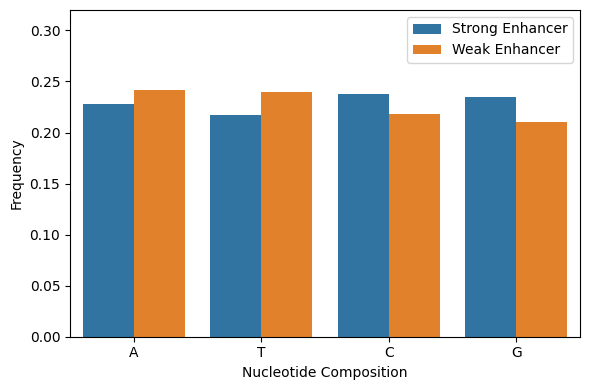

In [6]:
def plot_grouped_bar_chart(data, title):
    """
    Plots a grouped bar chart comparing nucleotide compositions across categories.
    
    Args:
        data (pd.DataFrame): DataFrame with columns ['Category', 'Nucleotide', 'Frequency'].
        title (str): Title of the plot.
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x='Nucleotide', y='Frequency', hue='Category')
    # plt.title(title)
    plt.xlabel('Nucleotide Composition')
    plt.ylabel('Frequency')
    plt.legend()  
    plt.ylim(0, 0.32)
    plt.tight_layout()

    with PdfPages('nucleotide_classification_composition.pdf') as pdf:
        pdf.savefig()
    plt.show()

# Calculate nucleotide frequencies for enhancer and non-enhancer sequences
enhancer_frequencies = calculate_nucleotide_frequencies(enhancer_sequences)
non_enhancer_frequencies = calculate_nucleotide_frequencies(non_enhancer_sequences)

# Prepare data for plotting
data = []
for category, freq_dict in zip(['Strong Enhancer', 'Weak Enhancer'], [enhancer_frequencies, non_enhancer_frequencies]):
    for nucleotide, frequency in freq_dict.items():
        data.append({'Category': category, 'Nucleotide': nucleotide, 'Frequency': frequency})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot grouped bar chart
plot_grouped_bar_chart(df, "Nucleotide Composition: Enhancers vs Non-Enhancers")

In [7]:
from tabulate import tabulate

# Prepare data for plotting
data = []
for category, freq_dict in zip(['Strong enhancers', 'Weak enhancers'], [enhancer_frequencies, non_enhancer_frequencies]):
    for nucleotide, frequency in freq_dict.items():
        data.append({'Category': category, 'Nucleotide': nucleotide, 'Frequency': frequency})


# Pivot the DataFrame
pivot_df = df.pivot(index='Category', columns='Nucleotide', values='Frequency')
pivot_df = pivot_df.applymap(lambda x: f"{x:.4f}")

print(tabulate(pivot_df, headers='keys', tablefmt='grid'))

+-----------------+--------+--------+--------+--------+
| Category        |      A |      C |      G |      T |
+=================+========+========+========+========+
| Strong Enhancer | 0.2276 | 0.2373 | 0.2347 | 0.2173 |
+-----------------+--------+--------+--------+--------+
| Weak Enhancer   | 0.2418 | 0.2181 | 0.2104 | 0.2397 |
+-----------------+--------+--------+--------+--------+
